In [10]:
%load_ext autoreload
%autoreload 2
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
pd.set_option("display.max_columns",999)
pd.set_option("display.max_rows",100)

import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.functional as F
from torch import optim

from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side
from src.data_processing import encode_batch, onehot_batch_decode, get_mia

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# loading various datasets 

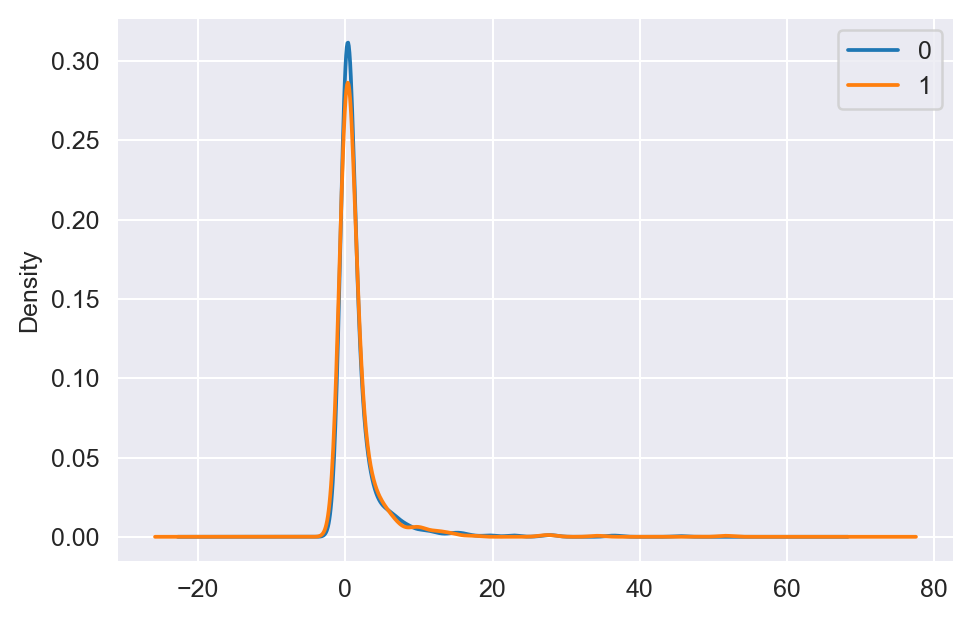

In [2]:
f,a = plt.subplots(figsize=(6,4))
palette = sns.color_palette('hsv', n_colors=13)
palette = [palette[8], palette[-1]]
sns.set_palette(palette)
pd.read_csv('../data/cedar_netmhc_scored.csv').groupby('agg_label')['EL_rank'].plot(kind='kde')
a.legend()

In [ ]:
import pandas as pd;
len(pd.read_excel('../data/raw_exports/neo_JUN2022_full_res.xlsx', sheet = '

In [11]:
dataset_prime = pd.read_csv('../data/nn_data/PRIME_dataset.csv')
dataset_neoepi_hp = pd.read_csv('../data/nn_data/neoepi_hp_hobohm_scored.csv')
dataset_cedar_hp = pd.read_csv('../data/nn_data/cedar_hp_hohobm_scored.csv')
    
len(dataset_prime), len(dataset_neoepi_hp), len(dataset_cedar_hp)

(7758, 5235, 5173)

In [45]:
len(not_done)

53

In [44]:
not_done = set(dataset_cedar_hp.query('dataset!="hp"')['HLA'].unique()).union(set(dataset_neoepi_hp.query('dataset!="hp"')['HLA']))
done = set(f"{x.split('_')[0][:7]}:{x.split('_')[0][7:]}" for x in os.listdir('../output_xls/') if 'HLA' in x)
not_done = sorted(set(x for x in not_done if x not in done))
' '.join(not_done)

'HLA-A02:02 HLA-A02:03 HLA-A02:05 HLA-A02:10 HLA-A02:11 HLA-A02:24 HLA-A03:02 HLA-A11:02 HLA-A25:01 HLA-A26:01 HLA-A29:02 HLA-A30:01 HLA-A30:02 HLA-A31:01 HLA-A33:01 HLA-A68:01 HLA-A68:02 HLA-A69:01 HLA-A80:01 HLA-B13:02 HLA-B18:01 HLA-B27:02 HLA-B35:03 HLA-B37:01 HLA-B37:04 HLA-B38:01 HLA-B39:01 HLA-B39:06 HLA-B40:02 HLA-B41:02 HLA-B44:02 HLA-B44:03 HLA-B44:08 HLA-B49:01 HLA-B51:01 HLA-B52:01 HLA-B54:01 HLA-B56:01 HLA-B57:01 HLA-C01:02 HLA-C03:03 HLA-C03:04 HLA-C04:01 HLA-C05:01 HLA-C06:02 HLA-C07:01 HLA-C07:02 HLA-C08:02 HLA-C12:02 HLA-C12:03 HLA-C14:02 HLA-C14:03 HLA-C15:02'

In [4]:
# Doesn't work??
display_side(dataset_prime.groupby('len')[['Peptide']].count(), 
             dataset_neoepi_hp.groupby('len')[['Peptide']].count(), 
             dataset_cedar_hp.groupby('len')[['Peptide']].count(),
            titles = ['Prime', 'neoepi', 'cedar_old'])

,Peptide
len,
8,71
9,5632
10,1629
11,425
12,1
,Peptide
len,
8,20
9,2724


In [5]:
display(dataset_prime.groupby('HLA')[['Peptide']].count().sort_values('Peptide',ascending=False))
display(dataset_neoepi_hp.groupby('HLA')[['Peptide']].count().sort_values('Peptide',ascending=False))
display(dataset_cedar_hp.groupby('HLA')[['Peptide']].count().sort_values('Peptide',ascending=False))

,Peptide
HLA,
A0201,1526
A1101,670
B0702,342
B1501,295
B3501,266
A0101,250
A2402,245
A3201,183
A0301,182


,Peptide
HLA,
HLA-A02:01,3288
HLA-A24:02,646
HLA-A11:01,268
HLA-B07:02,215
HLA-A03:01,142
HLA-B27:05,130
HLA-B15:01,128
HLA-B35:01,114
HLA-A02:06,104


,Peptide
HLA,
HLA-A02:01,3294
HLA-A24:02,673
HLA-A11:01,257
HLA-B07:02,214
HLA-B27:05,132
HLA-A03:01,127
HLA-B15:01,118
HLA-B35:01,109
HLA-A02:06,103


In [6]:
ics = pkl_load('../output/ic_results_dict.pkl')
ics.keys(), ics[8].keys(), ics[8]['HLA-A0101'].keys()

(dict_keys([8, 9, 10, 11, 12]),
 dict_keys(['HLA-A0101', 'HLA-A0201', 'HLA-A0206', 'HLA-A0301', 'HLA-A1101', 'HLA-A2402', 'HLA-B0702', 'HLA-B0801,', 'HLA-B1501', 'HLA-B2705', 'HLA-B3501', 'HLA-B4001']),
 dict_keys(['0.5', '0.1']))

In [20]:
ics[9]['HLA-A0201']['0.1']

array([0.13285214, 0.72396982, 0.09337318, 0.21677506, 0.0444653 ,
       0.14364564, 0.07854092, 0.092098  , 0.59973195])

In [18]:
get_mia(ics[9]['HLA-A0201']['0.5'], 0.3)

array([0, 2, 3, 4, 5, 6, 7], dtype=int64)

In [15]:
for k1 in ics.keys():
    for k2 in ics[k1].keys():
        k3 = '0.5'
        # for k3 in ics[k1][k2].keys():
        print(k1,k2,k3, '\n', ics[k1][k2][k3],'\n',get_mia(ics[k1][k2][k3]))

8 HLA-A0101 0.5 
 [0.10426629 0.32981354 0.35519087 0.05169463 0.04807597 0.0540455
 0.07578892 0.97498005] 
 [0 3 4 5 6]
8 HLA-A0201 0.5 
 [0.30632842 0.93592773 0.15993166 0.16441977 0.19821942 0.18021345
 0.13964885 0.72296146] 
 [2 3 4 5 6]
8 HLA-A0206 0.5 
 [0.44108713 0.6601617  0.25473291 0.21868807 0.27714616 0.22662205
 0.19608277 0.75832304] 
 [2 3 4 5 6]
8 HLA-A0301 0.5 
 [0.53085026 0.54140276 0.20032376 0.18213725 0.13866436 0.20711935
 0.08748633 0.9738373 ] 
 [2 3 4 5 6]
8 HLA-A1101 0.5 
 [0.45709258 0.67600876 0.19715565 0.23179674 0.19537967 0.21943188
 0.1119616  0.98886932] 
 [2 3 4 5 6]
8 HLA-A2402 0.5 
 [0.11515439 0.68316874 0.06277698 0.05797541 0.0607205  0.0613237
 0.09421772 0.69281855] 
 [0 2 3 4 5 6]
8 HLA-B0702 0.5 
 [0.12608093 0.87949517 0.08040786 0.09135675 0.09638202 0.08908612
 0.11297601 0.63239184] 
 [0 2 3 4 5 6]
8 HLA-B0801, 0.5 
 [0.06974761 0.19407582 0.11856501 0.08749588 0.25639868 0.05800621
 0.05998525 0.1446338  0.51604236 0.87466053 0.9629

# Exploration

In [8]:
hp_8mers = pd.concat([pd.read_csv(f'../output/{j}mers_humanproteome_chunk_{i}.pep',header=None) for i in [0,1,2,3] for j in [8,9,10,11,12]])

In [9]:
x=pd.read_csv('../output/8mers_humanproteome_chunk_0.txt')
x['count'] = x['uniprot_id'].apply(lambda x: len(x.split(',')))